# Gaussian processes and Bayesian optimization

In this assignment you will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Installation
New libraries that are required for this tasks can be installed with the following command (if you use Anaconda):

```bash
pip install GPy 
pip install gpyopt 
pip install xgboost 
```

You can also follow installtaion guides from <a href="https://github.com/SheffieldML/GPy">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/firststeps/index.html">GPyOpt</a> if you want to build them from source

You will also need following libraries: ```numpy```, ```scikit-learn```, ```matplotlib```

In [ ]:
! conda install pyqt=4

In [ ]:
! pip install GPy

In [ ]:
! pip install gpyopt

In [ ]:
! pip install xgboost

In [1]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.cross_validation import cross_val_score
import time
from grader import Grader
%matplotlib inline

 /usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.


### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [2]:
grader = Grader()

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [3]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3.,3.,(n,1))
    y = np.sin(X) + np.random.randn(n,1)*noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3.,3.,(n,1))
    y = np.random.randn(n,1)*noise_variance**0.5
    return X, y

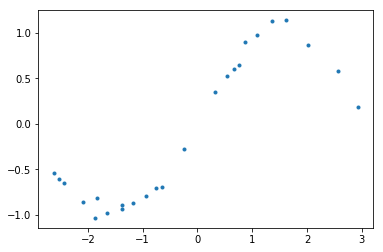

In [4]:
# Create data points
X, y = generate_points()
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, you will need to define a kernel. For Gaussian (GBF) kernel you can use *GPy.kern.RBF*
function.

<b> Task 1.1: </b> Create RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between 6-th and 10-th points (one-based indexing system). Submit a single number. 
<br><b>Hint:</b> use ```.K``` property of kernel object.

In [5]:
kernel = GPy.kern.RBF(1,variance=1.5,lengthscale=2)
kernel_59 = kernel.K(X,X)[5][9]
grader.submit_GPy_1(kernel_59)

Current answer for task 1.1 is: 1.0461813545396959


In [28]:
token = "S1k0ElMEuHiYph09"
submit(token)

Submitted to Coursera platform. See results on assignment page!


<b> Task 1.2: </b> Fit GP into generated data. Use kernel from previous task. Submit predicted mean and vairance at position $x=1$.
<br><b>Hint:</b> use ```GPy.models.GPRegression``` class.

In [22]:
model = GPy.models.GPRegression(X,y,kernel)
mean, variance = model.predict(np.array([[1]]))
grader.submit_GPy_2(mean, variance)

Current answer for task 1.2 (mean) is: 0.6646774926102939
Current answer for task 1.2 (variance) is: 1.100147822379058


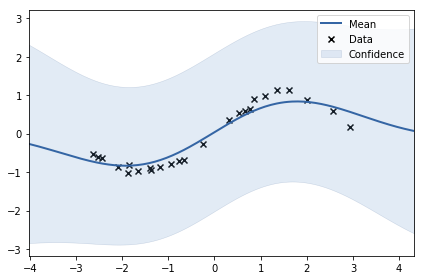

In [23]:
model.plot()
plt.show()

We see that model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see current parameters below:

In [24]:
model

GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


<b> Task 1.3: </b> Optimize length-scale, variance and noise component of the model and submit optimal length-scale value of the kernel. 
<br><b>Hint:</b> Use ```.optimize()``` function of the model and ```.lengthscale``` property of the kernel.

In [26]:
model.optimize()
lengthscale = model.rbf.lengthscale
grader.submit_GPy_3(lengthscale)

Current answer for task 1.3 is: 1.6252681851920923


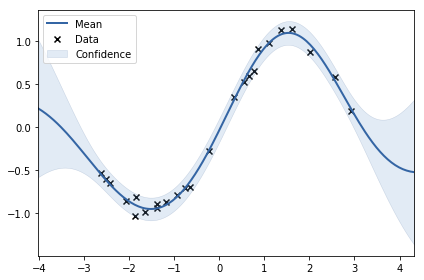

In [27]:
model.plot()
plt.show()

As you see, process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into  noise or signal.

<b> Task 1.4: </b> Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component.
<br><b>Note:</b> generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

In [44]:
X, y = generate_noise(noise_variance=10)
model1 = GPy.models.GPRegression(X,y,kernel)
model1.optimize()
noise = model1.Gaussian_noise.variance

In [45]:
X, y = generate_points(noise_variance=0)
model = GPy.models.GPRegression(X,y,kernel)
model.optimize()
just_signal = model.Gaussian_noise.variance

In [46]:
token = "a2MR5iwhXm1XDTjL"

In [47]:
grader.submit_GPy_4(noise, just_signal)
submit(token)

Current answer for task 1.4 (noise) is: 13.56373749387668
Current answer for task 1.4 (just signal) is: 1.710869695901859e-15
Submitted to Coursera platform. See results on assignment page!


#### Sparce GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure time that is consumed for prediction of mean and variance for each point. We will then try to use indusing inputs and find optimal number of points according to quality-time tradeoff.

For sparse model with inducing points you should use ```GPy.models.SparseGPRegression``` class. You can set number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

<b>Task 1.5</b>: Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit SparseGPRegression with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [49]:
X, y = generate_points(1000)

In [50]:
start = time.time()
model = GPy.models.GPRegression(X,y,kernel)
# model.optimize()
mean, variance = model.predict(np.array([[1]]))
time_gp = time.time()-start

In [51]:
start = time.time()
model = GPy.models.SparseGPRegression(X,y,kernel)
# model.optimize()
mean, variance = model.predict(np.array([[1]]))
time_sgp = time.time()-start

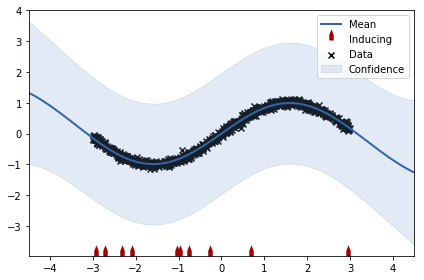

In [52]:
model.plot()
plt.show()

In [54]:
grader.submit_GPy_5(time_gp / time_sgp)
submit(token)

Current answer for task 1.5 is: 6.371909059075061
Submitted to Coursera platform. See results on assignment page!


## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [56]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First we have to define optimization function and domains.

In [57]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              gamma=int(parameters[1]),
                              min_child_weight = parameters[4]), 
                X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [58]:
baseline = -cross_val_score(XGBRegressor(), X, y, scoring='neg_mean_squared_error').mean()
baseline

3498.951701204653

In [59]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
            {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
            {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
            {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
         ]

In [60]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)

In [61]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

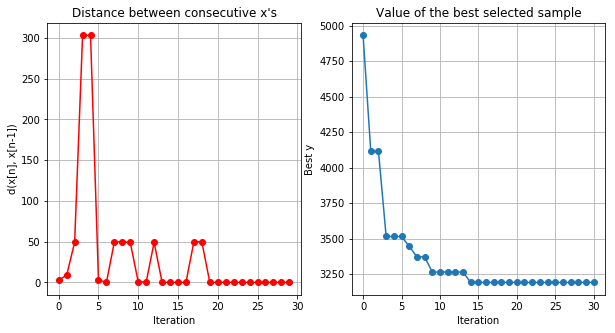

In [62]:
optimizer.plot_convergence()

Best values of parameters:

In [63]:
optimizer.X[np.argmin(optimizer.Y)]

array([9.16875502e-02, 1.89369338e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [64]:
print('MSE:', np.min(optimizer.Y), 'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3191.9802032093703 Gain: 109.61696121068165


We were able to get 9% boost without tuning parameters by hand! Let's see if you can do the same. 

<b>Task 2.1:</b> Tune SVR model. Find optimal values for three parameters: ```C```, ```epsilon``` and ```gamma```. Use range (1e-5, 1000) for ```C```, (1e-5, 10) for ```epsilon``` and ```gamma```. Use MPI as acquisition function with weight 0.1. Submit optimal value of epsilon that was found by a model.

In [66]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
                                SVR(C=parameters[0],epsilon=parameters[1],gamma=parameters[2]),
                                    X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

In [67]:
bounds = [
            {'name': 'C', 'type': 'continuous', 'domain': (0.00001, 1000)},
            {'name': 'epsilon', 'type': 'continuous', 'domain': (0.00001, 10)},
            {'name': 'gamma', 'type': 'continuous', 'domain': (0.00001, 10)},
         ]

In [68]:
baseline = -cross_val_score(SVR(), X, y, scoring='neg_mean_squared_error').mean()
baseline

6067.652263997995

In [69]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                acquisition_type ='MPI',
                                                acquisition_par = 0.1,
                                                exact_eval=True)

In [70]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

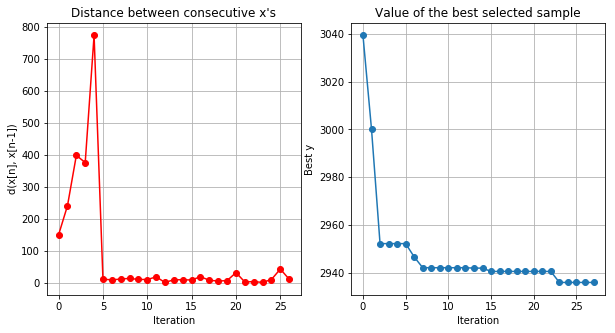

In [71]:
optimizer.plot_convergence()

In [72]:
best_epsilon = optimizer.X[np.argmin(optimizer.Y)][1]
grader.submit_GPyOpt_1(best_epsilon)

Current answer for task 2.1 is: 10.0


<b>Task 2.2:</b> For the model above submit boost in improvement that you got after tuning hyperparameters (output percents) [e.g. if baseline MSE was 40 and you got 20, output number 200]

In [74]:
performance_boost = baseline/np.min(optimizer.Y)
grader.submit_GPyOpt_2(performance_boost*100)

Current answer for task 2.2 is: 206.6715939803401


### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [ ]:
STUDENT_EMAIL = # EMAIL HERE
STUDENT_TOKEN = # TOKEN HERE
grader.status()

If you want to submit these answers, run cell below

In [7]:
def submit(token):
    grader.submit("goutham7r@gmail.com", token)

In [75]:
submit(token)

Submitted to Coursera platform. See results on assignment page!
